1. IMPORT LIBRARIES

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ssl
import warnings

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from IPython.display import clear_output

warnings.filterwarnings('ignore')
ssl._create_default_https_context = ssl._create_unverified_context

print('import lebreries success!')

import lebreries success!


2. HYPERPARAMETRERS AND DIRECTORIES

In [84]:
train_dir = "./emotion/train"
test_dir = "./emotion/test"

SEED = 12
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 10
FINE_TUNING_EPOCHS = 10
LR = 0.01
NUM_CLASSES = 7
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]

3. DATA LOADING AND PRE-PROCESSING

In [85]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 23077 images belonging to 7 classes.
Found 5767 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


4. Images with different emotions

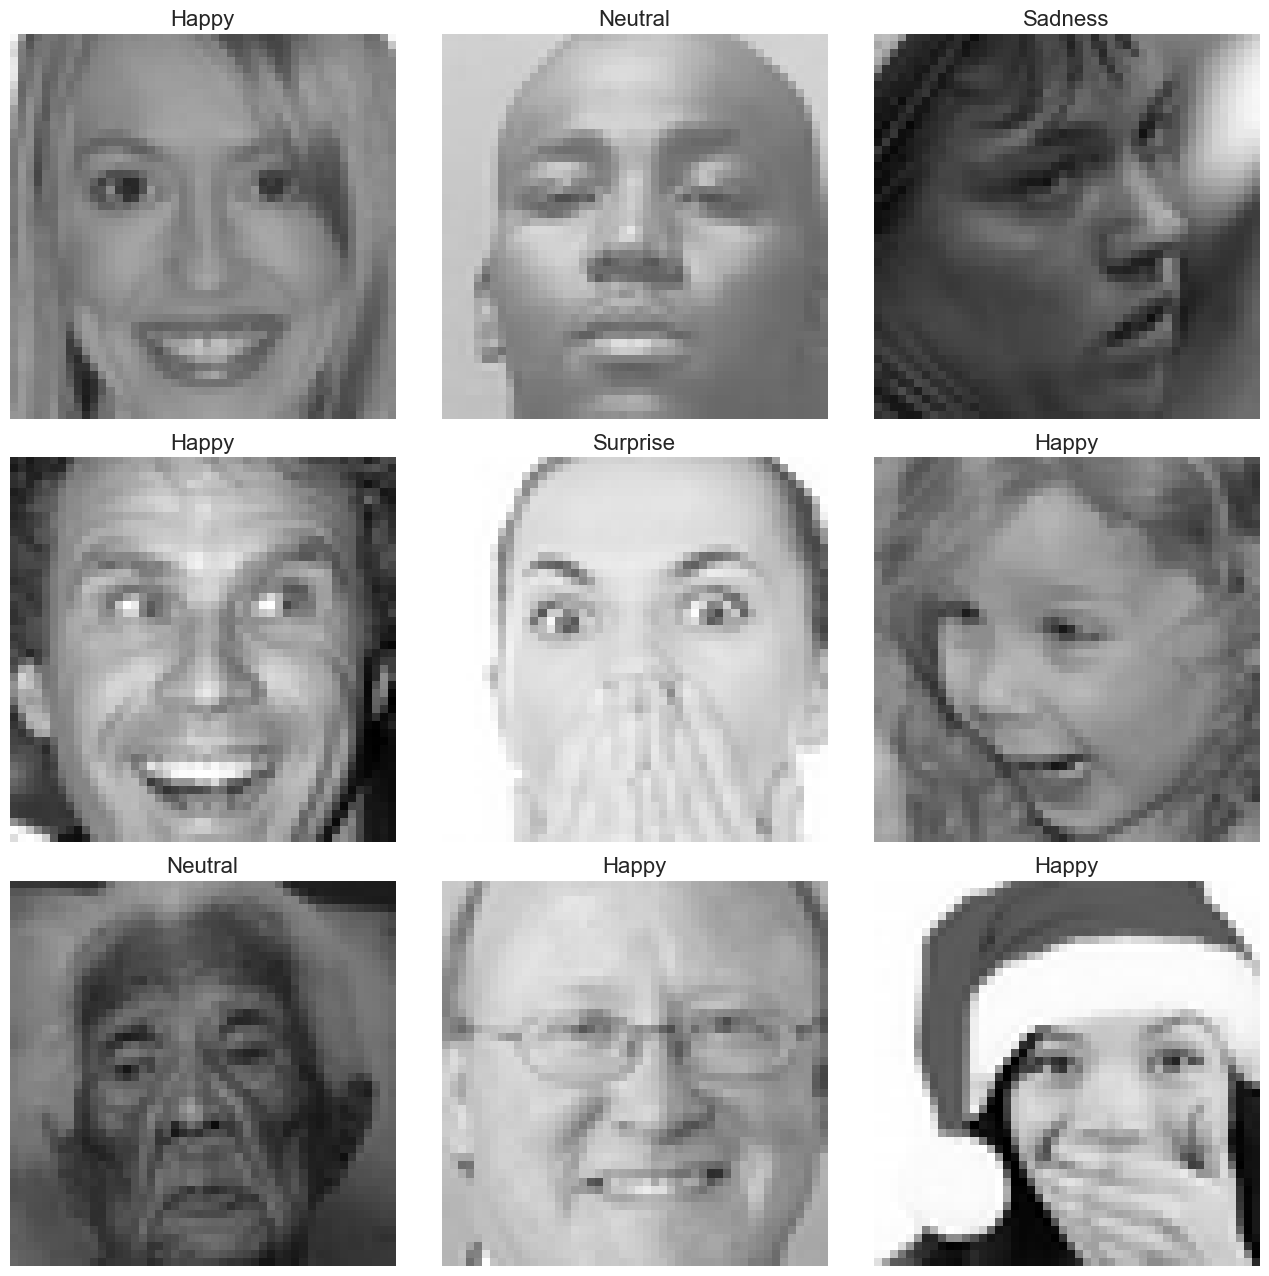

In [86]:
# Helper Functions
def display_one_image(image, title, subplot, color):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16)
    
def display_nine_images(images, titles, title_colors=None):
    subplot = 331
    plt.figure(figsize=(13,13))
    for i in range(9):
        color = 'black' if title_colors is None else title_colors[i]
        display_one_image(images[i], titles[i], 331+i, color)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def image_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
    class_idx = np.argmax(label, axis=-1)
    prediction_idx = np.argmax(prediction, axis=-1)
    if class_idx == prediction_idx:
        return f'{CLASS_LABELS[prediction_idx]} [correct]', 'black'
    else:
        return f'{CLASS_LABELS[prediction_idx]} [incorrect, should be {CLASS_LABELS[class_idx]}]', 'red'

def get_titles(images, labels, model):
    predictions = model.predict(images)
    titles, colors = [], []
    for label, prediction in zip(classes, predictions):
        title, color = image_title(label, prediction)
        titles.append(title)
        colors.append(color)
    return titles, colors

img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )
clear_output()

images, classes = next(img_generator)
class_idxs = np.argmax(classes, axis=-1) 
labels = [CLASS_LABELS[idx] for idx in class_idxs]
display_nine_images(images, labels)

5. Data distribution (count) among differnt emotions

In [87]:
fig = px.bar(x = CLASS_LABELS_EMOJIS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

6. DenseNet169 Transfer Learning

In [88]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet169(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(0.1), 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
  
    return model

7. Summary of model

In [89]:
model = define_compile_model()
clear_output()

# Feezing the feature extraction layers
model.layers[1].trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_average_pooling2d_1  (None, 1664)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               426240    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                           

Training and Fine-Tuning
8. Training model with freezed layers of DenseNer169

In [90]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=EARLY_STOPPING_CRITERIA,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )

history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks= [earlyStoppingCallback])

history = pd.DataFrame(history.history)

Epoch 1/10
361/361 [==============================] - 126s 332ms/step - loss: 9.9911 - accuracy: 0.2533 - val_loss: 5.5019 - val_accuracy: 0.2492
Epoch 2/10
361/361 [==============================] - 119s 329ms/step - loss: 3.4852 - accuracy: 0.3889 - val_loss: 2.6869 - val_accuracy: 0.3107
Epoch 3/10
361/361 [==============================] - 119s 328ms/step - loss: 1.8696 - accuracy: 0.4438 - val_loss: 2.0054 - val_accuracy: 0.4019
Epoch 4/10
361/361 [==============================] - 119s 329ms/step - loss: 1.4606 - accuracy: 0.4898 - val_loss: 1.4103 - val_accuracy: 0.4911
Epoch 5/10
361/361 [==============================] - 119s 330ms/step - loss: 1.3338 - accuracy: 0.5182 - val_loss: 1.3441 - val_accuracy: 0.5192
Epoch 6/10
361/361 [==============================] - 120s 332ms/step - loss: 1.2774 - accuracy: 0.5402 - val_loss: 1.2996 - val_accuracy: 0.5488
Epoch 7/10
361/361 [==============================] - 122s 339ms/step - loss: 1.2374 - accuracy: 0.5584 - val_loss: 1.2084 -

9. Fine Tuning

In [91]:

# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.legacy.Nadam(0.001), # lower learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_ = model.fit(x=train_generator, epochs=10, validation_data=validation_generator)
history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)

Epoch 1/10
361/361 [==============================] - 145s 362ms/step - loss: 1.4429 - accuracy: 0.5064 - val_loss: 1.7110 - val_accuracy: 0.4966
Epoch 2/10
361/361 [==============================] - 132s 365ms/step - loss: 1.3590 - accuracy: 0.5358 - val_loss: 1.6646 - val_accuracy: 0.4527
Epoch 3/10
361/361 [==============================] - 131s 364ms/step - loss: 1.3525 - accuracy: 0.5429 - val_loss: 1.4309 - val_accuracy: 0.5414
Epoch 4/10
361/361 [==============================] - 132s 366ms/step - loss: 1.3084 - accuracy: 0.5593 - val_loss: 1.2833 - val_accuracy: 0.5504
Epoch 5/10
361/361 [==============================] - 132s 365ms/step - loss: 1.3171 - accuracy: 0.5528 - val_loss: 1.3234 - val_accuracy: 0.5382
Epoch 6/10
361/361 [==============================] - 131s 362ms/step - loss: 1.2629 - accuracy: 0.5791 - val_loss: 1.2462 - val_accuracy: 0.5670
Epoch 7/10
361/361 [==============================] - 133s 367ms/step - loss: 1.2475 - accuracy: 0.5848 - val_loss: 1.3508 -

In [92]:
# Un-Freezing the feature extraction layers for fine tuning 
model.layers[1].trainable = True

model.compile(optimizer=tf.keras.optimizers.legacy.Nadam(0.001), # lower learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_ = model.fit(x=train_generator, epochs=10, validation_data=validation_generator)
history = pd.concat([history, pd.DataFrame(history_.history)], ignore_index=True)

Epoch 1/10
361/361 [==============================] - 143s 358ms/step - loss: 1.2244 - accuracy: 0.6025 - val_loss: 1.2680 - val_accuracy: 0.5929
Epoch 2/10
361/361 [==============================] - 132s 365ms/step - loss: 1.1875 - accuracy: 0.6131 - val_loss: 1.2641 - val_accuracy: 0.5887
Epoch 3/10
361/361 [==============================] - 131s 363ms/step - loss: 1.1574 - accuracy: 0.6184 - val_loss: 1.2262 - val_accuracy: 0.5956
Epoch 4/10
361/361 [==============================] - 131s 364ms/step - loss: 1.1361 - accuracy: 0.6279 - val_loss: 1.1624 - val_accuracy: 0.5968
Epoch 5/10
361/361 [==============================] - 131s 363ms/step - loss: 1.1264 - accuracy: 0.6308 - val_loss: 1.2903 - val_accuracy: 0.5714
Epoch 6/10
361/361 [==============================] - 131s 363ms/step - loss: 1.1076 - accuracy: 0.6373 - val_loss: 1.2373 - val_accuracy: 0.5968
Epoch 7/10
361/361 [==============================] - 132s 365ms/step - loss: 1.1057 - accuracy: 0.6405 - val_loss: 1.1742 -

KeyboardInterrupt: 

10. Training plots

In [80]:
x = px.line(data_frame= history , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [81]:
x = px.line(data_frame= history , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

11. Model Evaluation

In [82]:
model.evaluate(test_generator)
preds = model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

113/113 [==============================] - 9s 82ms/step


12. Confusion Matrix

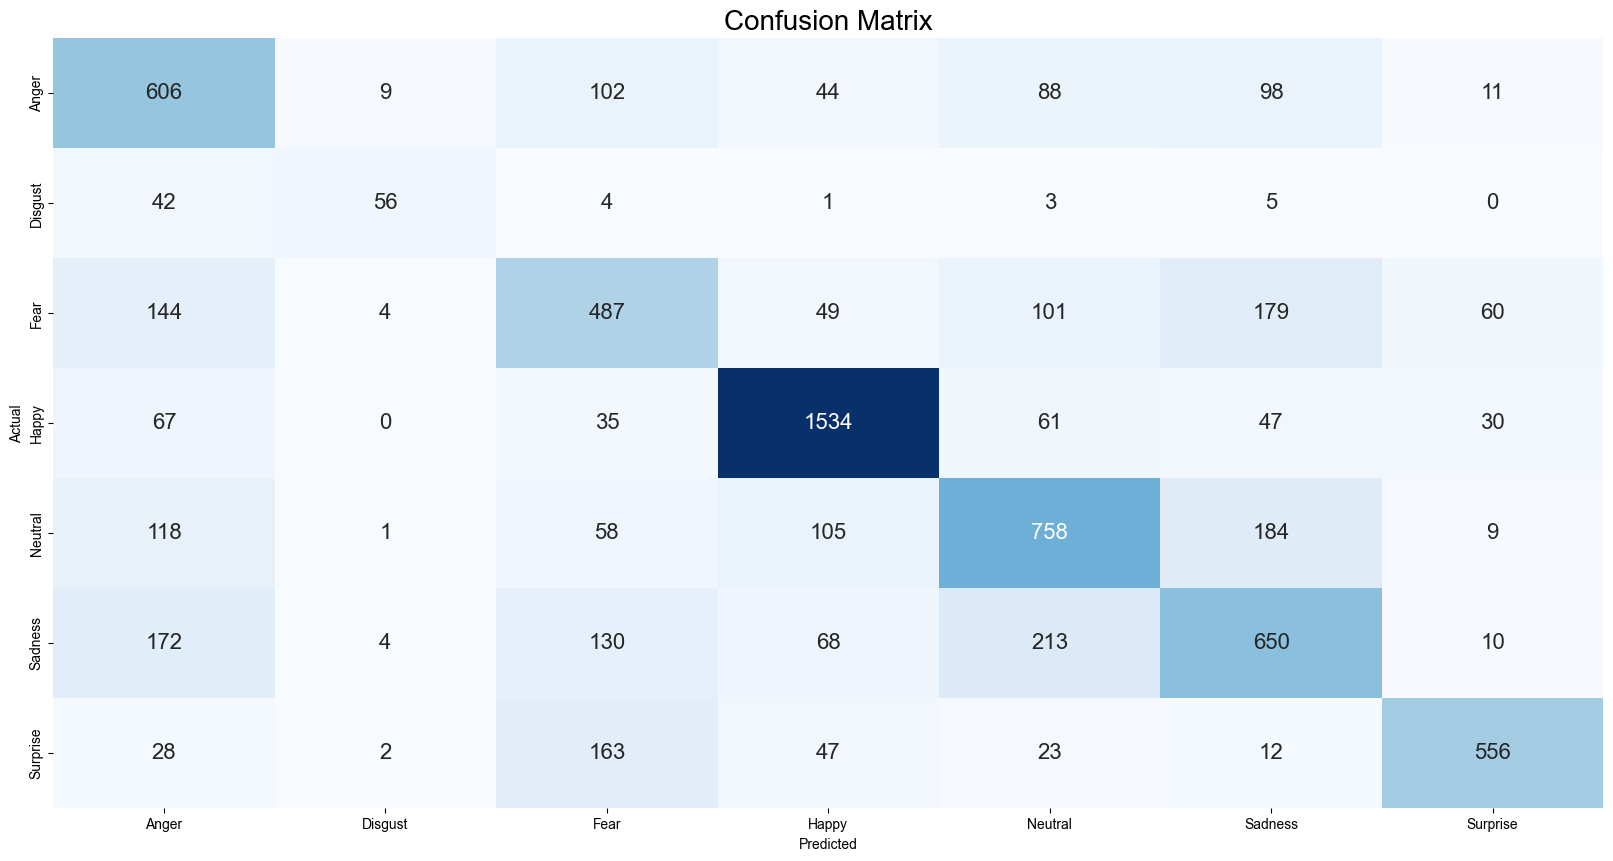

In [70]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

13. Classification Report

In [71]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.51      0.63      0.57       958
           1       0.74      0.50      0.60       111
           2       0.50      0.48      0.49      1024
           3       0.83      0.86      0.85      1774
           4       0.61      0.61      0.61      1233
           5       0.55      0.52      0.54      1247
           6       0.82      0.67      0.74       831

    accuracy                           0.65      7178
   macro avg       0.65      0.61      0.63      7178
weighted avg       0.65      0.65      0.65      7178



14. Multiclass AUC Curve

ROC AUC score: 0.9053660788308537


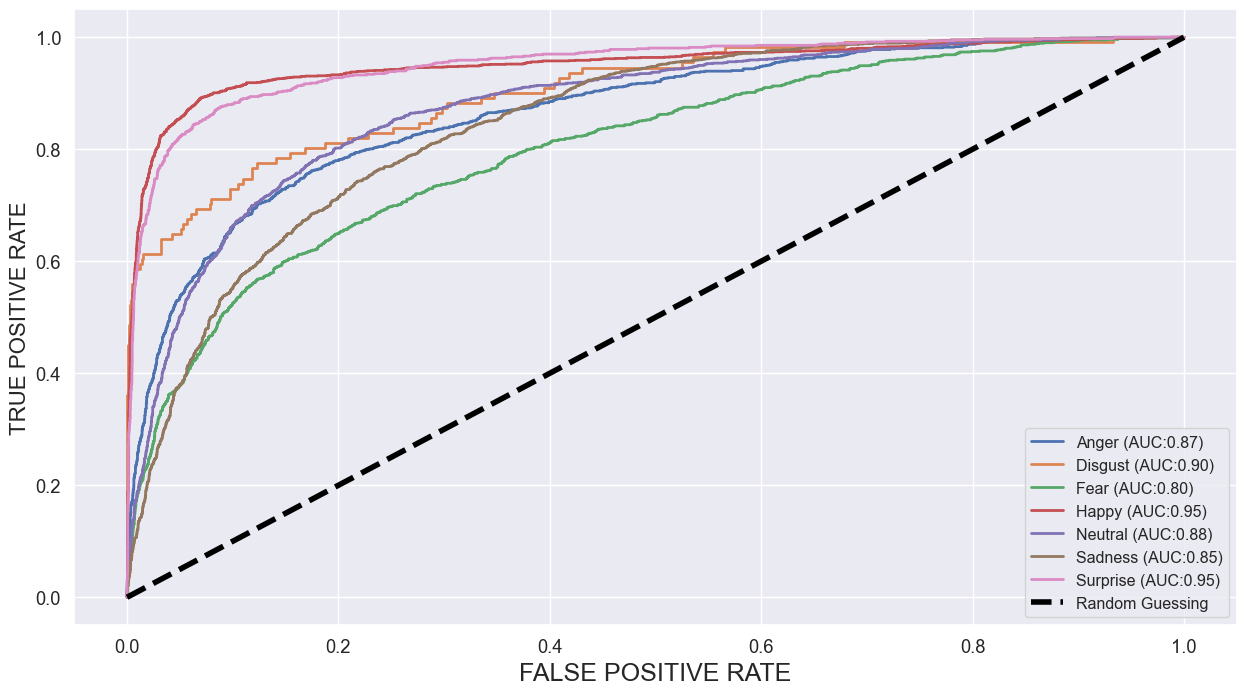

In [72]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [73]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

ROC-AUC Score  =  0.8850725196142706
